<a href="https://colab.research.google.com/github/Jmontoyaor/Computational-electromagnetics/blob/main/Workshop2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ejemplo 16,5

 MÉTODO DE GALERKIN - LÍNEA MICROSTRIP


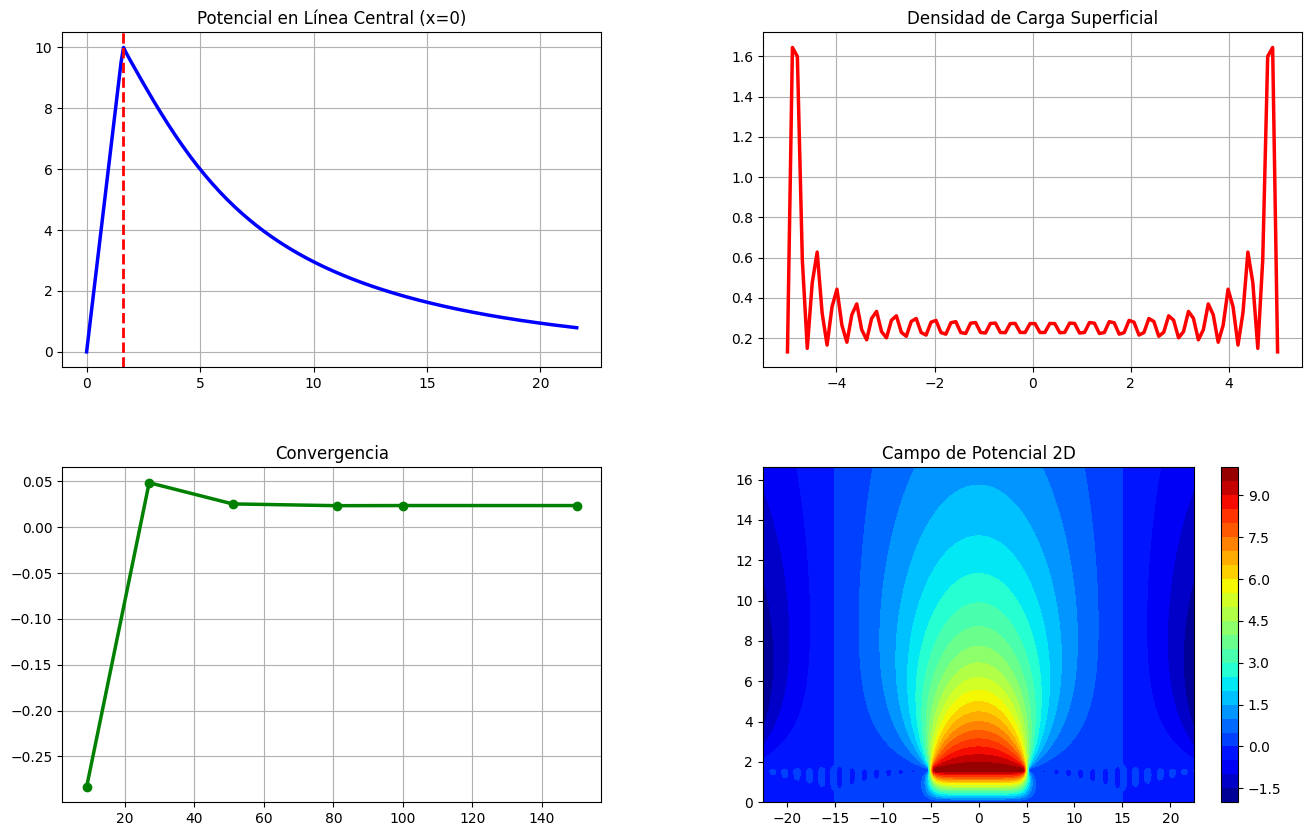

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'

class MicrostripGalerkin:

    def __init__(self, W=40, h=16, d=0.03, er=4.3, V0=10, N=51):
        self.W = W
        self.h = h
        self.d = d
        self.er = er
        self.V0 = V0
        self.N = N if N % 2 == 1 else N + 1
        self.e0 = 8.854e-12

    def calculate_An(self, n):
        n_pi = n * np.pi
        numerator = np.sin(n_pi * self.W / (2 * self.d))
        denominator = np.sinh(n_pi * self.h / self.d)
        if abs(denominator) < 1e-100:
            return 0
        return (4 * self.V0 / n_pi) * (numerator / denominator)

    def calculate_Cn(self, n):
        n_pi = n * np.pi
        sin_term = np.sin(n_pi * self.W / (2 * self.d))
        return (4 * self.V0 / n_pi) * sin_term

    def potential_dielectric(self, x, y, n_terms=None):
        if n_terms is None:
            n_terms = self.N
        phi = 0
        for n in range(1, n_terms + 1, 2):
            An = self.calculate_An(n)
            n_pi = n * np.pi
            phi += An * np.sinh(n_pi * y / self.d) * np.cos(n_pi * x / self.d)
        return phi

    def potential_air(self, x, y, n_terms=None):
        if n_terms is None:
            n_terms = self.N
        phi = 0
        for n in range(1, n_terms + 1, 2):
            Cn = self.calculate_Cn(n)
            n_pi = n * np.pi
            phi += Cn * np.exp(-n_pi * (y - self.h) / self.d) * np.cos(n_pi * x / self.d)
        return phi

    def calculate_center_line(self, num_points=200, n_terms=None):
        y_max = self.h + 20
        y_values = np.linspace(0, y_max, num_points)
        phi_values = np.zeros(num_points)

        for i, y in enumerate(y_values):
            if y <= self.h:
                phi_values[i] = self.potential_dielectric(0, y, n_terms)
            else:
                phi_values[i] = self.potential_air(0, y, n_terms)
        return y_values, phi_values

    def calculate_charge_density(self, num_points=100):
        x_values = np.linspace(-self.W/2, self.W/2, num_points)
        rho_values = np.zeros(num_points)

        for i, x in enumerate(x_values):
            sum_diel_deriv = 0
            sum_air_deriv = 0
            for n in range(1, self.N + 1, 2):
                An = self.calculate_An(n)
                Cn = self.calculate_Cn(n)
                n_pi_d = (n*np.pi)/self.d
                cos_term = np.cos(n*np.pi * x / self.d)

                sum_diel_deriv += An * n_pi_d * np.cosh(n*np.pi*self.h/self.d) * cos_term
                sum_air_deriv += Cn * (-n_pi_d) * cos_term

            rho_intuitiva = self.e0 * (self.er * sum_diel_deriv - sum_air_deriv)
            rho_values[i] = rho_intuitiva * 1e9
        return x_values, rho_values

    def calculate_convergence(self):
        n_values = [n for n in [9, 27, 51, 81, 100, 150] if n <= self.N]
        phi_values = [self.potential_dielectric(self.d/4, self.h/2, n) for n in n_values]
        return np.array(n_values), np.array(phi_values)

    def calculate_field_2d(self, x_points=150, y_points=150):
        x_range = self.d * 1.5
        x_values = np.linspace(-x_range/2, x_range/2, x_points)
        y_values = np.linspace(0, self.h + 15, y_points)

        X, Y = np.meshgrid(x_values, y_values)
        phi_field = np.zeros_like(X)

        for i in range(y_points):
            for j in range(x_points):
                if Y[i, j] <= self.h:
                    phi_field[i, j] = self.potential_dielectric(X[i, j], Y[i, j])
                else:
                    phi_field[i, j] = self.potential_air(X[i, j], Y[i, j])
        return X, Y, phi_field

# ------------------------------ PLOT RESULTADOS ------------------------------
def plot_results(microstrip):
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0])
    y_vals, phi_vals = microstrip.calculate_center_line()
    ax1.plot(y_vals, phi_vals, 'b-', linewidth=2.5)
    ax1.axvline(x=microstrip.h, color='red', linestyle='--', linewidth=2)

    ax1.set_title('Potencial en Línea Central (x=0)')
    ax1.grid(True)

    ax2 = fig.add_subplot(gs[0, 1])
    x_vals, rho_vals = microstrip.calculate_charge_density()
    ax2.plot(x_vals, rho_vals, 'r-', linewidth=2.5)
    ax2.set_title('Densidad de Carga Superficial')
    ax2.grid(True)

    ax3 = fig.add_subplot(gs[1, 0])
    n_vals, conv_vals = microstrip.calculate_convergence()
    ax3.plot(n_vals, conv_vals, 'go-', linewidth=2.5)
    ax3.set_title('Convergencia')
    ax3.grid(True)

    ax4 = fig.add_subplot(gs[1, 1])
    X, Y, phi_field = microstrip.calculate_field_2d()
    contour = ax4.contourf(X, Y, phi_field, levels=25, cmap='jet')
    plt.colorbar(contour, ax=ax4)
    ax4.set_title('Campo de Potencial 2D')

    return fig

# ------------------------------ ANIMACIÓN ------------------------------
def animate_convergence(microstrip, n_max=151):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    y_vals = np.linspace(0, microstrip.h + 20, 200)
    n_values = list(range(1, min(n_max, microstrip.N) + 1, 2))
    line1, = ax1.plot([], [], 'b-', linewidth=2)
    ax1.set_xlim(0, microstrip.h + 20)
    ax1.set_ylim(0, microstrip.V0 * 1.1)

    line2, = ax2.plot([], [], 'go-', linewidth=2)
    ax2.set_xlim(0, n_max)

    n_conv = []
    phi_conv = []

    def init():
        return line1, line2

    def animate(frame):
        n = n_values[frame]
        phi_vals = []
        for y in y_vals:
            phi_vals.append(
                microstrip.potential_dielectric(0, y, n) if y <= microstrip.h
                else microstrip.potential_air(0, y, n)
            )
        line1.set_data(y_vals, phi_vals)

        n_conv.append(n)
        phi_conv.append(microstrip.potential_dielectric(microstrip.d/4, microstrip.h/2, n))
        line2.set_data(n_conv, phi_conv)

        return line1, line2

    ani = FuncAnimation(fig, animate, init_func=init, frames=len(n_values), interval=130, blit=True)
    plt.close()
    return HTML(ani.to_html5_video())

# =====================================================================
print("="*70)
print(" MÉTODO DE GALERKIN - LÍNEA MICROSTRIP")
print("="*70)

microstrip = MicrostripGalerkin(
   W=10, h=1.6, d=30, er=4.3, V0=10, N=151
)

fig_static = plot_results(microstrip)
plt.show()

# Para animación:
# video = animate_convergence(microstrip)
# video


In [25]:
# Animación
print("\n🎬 Generando animación de convergencia...\n")
animate_convergence(microstrip, n_max=151)


🎬 Generando animación de convergencia...



# Ejemplo 16.7 usando  FEM (Finite Element Method):



In [40]:
!pip install scikit-fem[all]

In [45]:
pip install --upgrade scikit-fem


Instalando scikit-fem y meshio...
Bibliotecas instaladas y cargadas.
Malla creada con 3750 elementos triangulares.
Ensamblando la matriz de rigidez...
Generando la gráfica de potencial...


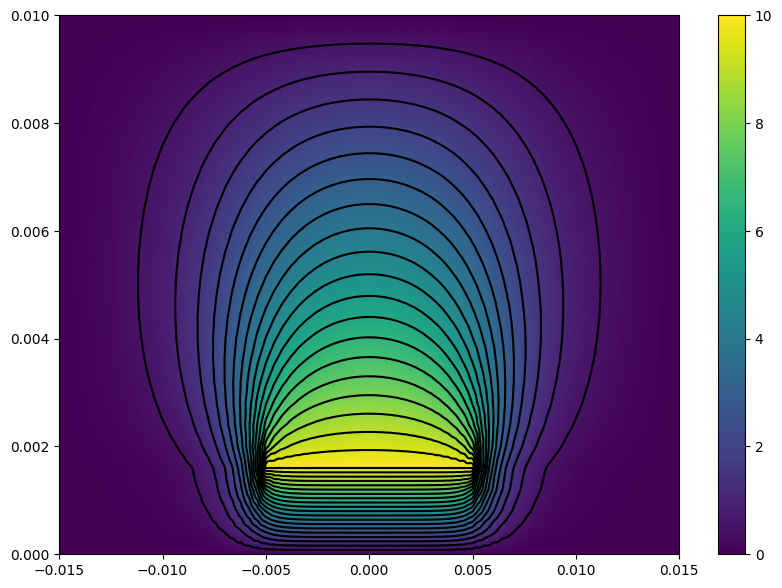

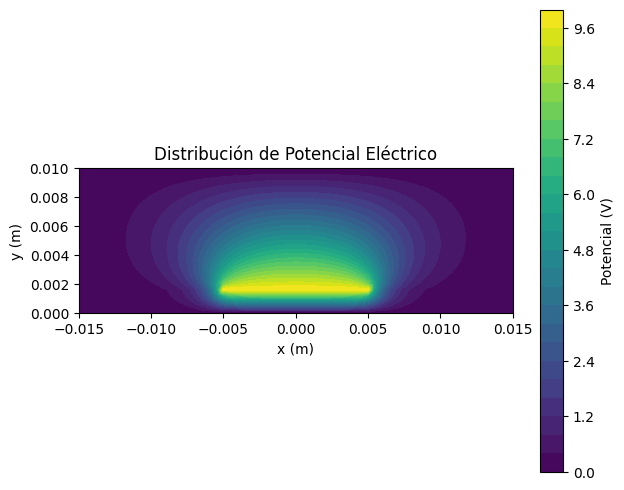

In [63]:
# --- 1. Instalar las bibliotecas necesarias para FEM ---
# scikit-fem es la biblioteca de elementos finitos
# meshio es para generar la malla
print("Instalando scikit-fem y meshio...")
!pip install scikit-fem[all] -q

import skfem as fem
from skfem.helpers import dot, grad
import numpy as np
import matplotlib.pyplot as plt

print("Bibliotecas instaladas y cargadas.")

# --- 2. Definir la Geometría y Parámetros ---
# (Ejemplo 16.5)
d = 30e-3     # Ancho de la caja (30 mm)
W = 10e-3     # Ancho de la tira (10 mm)
h = 1.6e-3    # Alto del dieléctrico (1.6 mm)
H_box = 10e-3 # Alto total de la caja (asumido, 10mm)
V0 = 10.0     # Potencial de la tira (10 V)
er = 4.3      # Permitividad relativa del dieléctrico

# --- 3. Crear la Malla (Mesh) ---
# Usamos 'MeshTri' de skfem para crear una malla de triángulos
# Refinamos la malla (mesh_size) para más precisión
mesh_size = 0.0004  # 0.4 mm

# Cantidad de puntos en cada dirección (+1 para incluir el borde)
nx = int(d / mesh_size) + 1
ny = int(H_box / mesh_size) + 1

# Crear la malla tensorial triangular
mesh = fem.MeshTri.init_tensor(
    np.linspace(-d/2, d/2, nx),
    np.linspace(0, H_box, ny)
)

print(f"Malla creada con {mesh.nelements} elementos triangulares.")



# --- 4. Definir el Espacio de Funciones ---
# Usamos ElementTriP1, que significa que en cada triángulo,
# el potencial es una función lineal (Plano)
element = fem.ElementTriP1()
basis = fem.Basis(mesh, element)

# --- 5. Definir la Física del Problema ---
# Esta función le dice a skfem cuál es la permitividad (epsilon)
# en cualquier punto (x, y) de la malla.
from skfem import BilinearForm

@BilinearForm
def laplace(u, v, w):
    epsilon = np.where(w.x[1] < h, er, 1.0)
    return dot(epsilon * grad(u), grad(v))

# --- 6. Ensamblar la Matriz de Rigidez (Stiffness Matrix) ---
# Este es el paso "Ensamblar" de FEM.
# skfem hace todo el trabajo de calcular [K^e] para cada triángulo
# y sumarlos en la matriz global [K_g]
print("Ensamblando la matriz de rigidez...")
K = laplace.assemble(basis)

## --- 7. Aplicar Condiciones de Frontera (versión correcta) ---
tol = 1e-9

# Identificar bordes en la geometría
bottom = mesh.facets_satisfying(lambda x: np.isclose(x[1], 0.0, atol=tol))
top    = mesh.facets_satisfying(lambda x: np.isclose(x[1], H_box, atol=tol))
left   = mesh.facets_satisfying(lambda x: np.isclose(x[0], -d/2, atol=tol))
right  = mesh.facets_satisfying(lambda x: np.isclose(x[0],  d/2, atol=tol))

strip  = mesh.facets_satisfying(lambda x: np.isclose(x[1], h, atol=tol) &
                                            (x[0] >= -W/2) &
                                            (x[0] <= W/2))

# Convertir a DOFs
ground_nodes = basis.get_dofs(facets=bottom)
top_nodes    = basis.get_dofs(facets=top)
left_nodes   = basis.get_dofs(facets=left)
right_nodes  = basis.get_dofs(facets=right)
strip_nodes  = basis.get_dofs(facets=strip)

# Crear vector de potencial
phi = np.zeros(basis.N)

# Aplicar valores de frontera
phi[ground_nodes] = 0.0
phi[top_nodes] = 0.0
phi[left_nodes] = 0.0
phi[right_nodes] = 0.0
phi[strip_nodes] = V0

# Extraer solo los índices

# Unir todos los DOFs con condición de Dirichlet
D = np.unique(np.concatenate([
    ground_nodes, top_nodes, left_nodes, right_nodes, strip_nodes
]))

# Resolver el sistema reducido
phi = fem.solve(*fem.condense(K, np.zeros_like(phi), phi, D=D))

# Aplicar el potencial del electrodo
phi[strip_nodes] = V0

# Resolver el sistema reducido (ESTE ES EL ÚNICO solve)
phi = fem.solve(*fem.condense(K, np.zeros_like(phi), phi, D=D))

# Aplicar el potencial del electrodo (asegura el nivel de referencia)
phi[strip_nodes] = V0


# --- 9. Graficar los Resultados ---
print("Generando la gráfica de potencial...")

from skfem.visuals.matplotlib import plot
fig, ax = plt.subplots(figsize=(10, 7))
levels = np.linspace(0, V0, 21)

plot(basis, phi, shading='gouraud', cmap='viridis',
     levels=levels, ax=ax)
plt.colorbar(ax.collections[0], ax=ax)
import matplotlib.pyplot as plt
import numpy as np

# Recuperar coordenadas y conectividad
x = mesh.p[0]
y = mesh.p[1]
triangles = mesh.t.T

plt.figure(figsize=(7,6))
contour = plt.tricontourf(x, y, triangles, phi, levels=30, cmap='viridis')
plt.colorbar(contour, label="Potencial (V)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Distribución de Potencial Eléctrico")
plt.gca().set_aspect('equal')
plt.show()



#16,8

Resolviendo Ejemplo 16.8 (Método de Momentos) con N = 50 segmentos.
Construyendo la matriz de acoplamiento [Z]...
Resolviendo [rho] = [Z_inv] * [V]...
¡Densidad de carga encontrada!


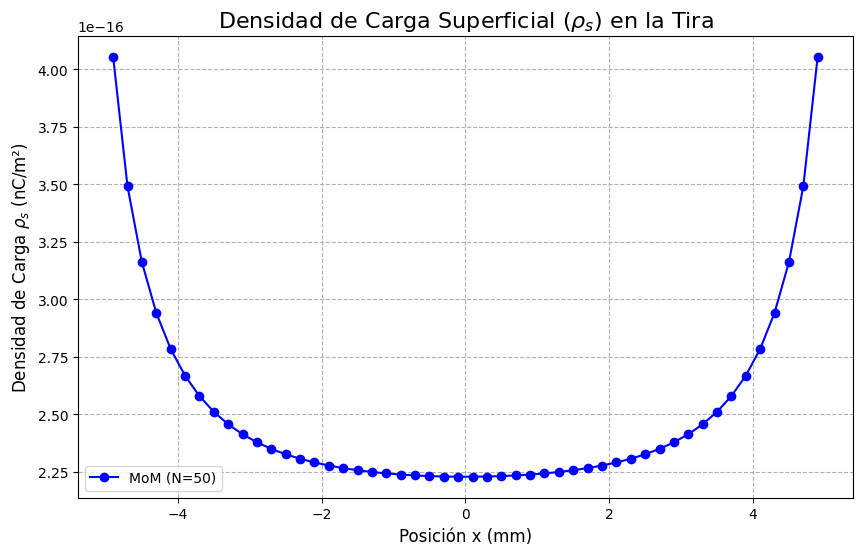


Usando la carga encontrada para calcular el potencial 2D...
Generando gráfica de potencial 2D...


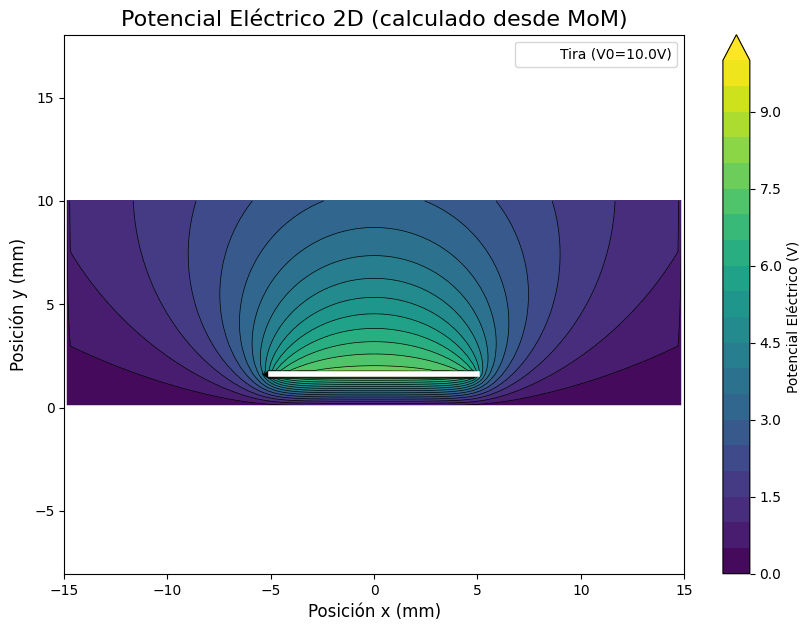

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Constantes del Problema (Ejemplo 16.5 / 16.8) ---
W = 10e-3     # Ancho de la tira (10 mm)
h = 1.6e-3    # Alto del dieléctrico (1.6 mm)
V0 = 10.0     # Potencial de la tira (10 V)
er = 4.3      # Permitividad relativa del dieléctrico
e0 = 8.854e-12 # Permitividad del vacío (F/m)
epsilon = er * e0  # Permitividad del dieléctrico

# --- 2. Parámetros del Método de Momentos (MoM) ---
N = 50        # Número de segmentos (células) en la tira
d_box = 30e-3 # Ancho de la caja (para la gráfica)
h_box = 10e-3 # Alto de la caja (para la gráfica)

print(f"Resolviendo Ejemplo 16.8 (Método de Momentos) con N = {N} segmentos.")

# --- 3. Discretización de la Geometría ---
dx = W / N
x_centers = np.linspace(-W/2 + dx/2, W/2 - dx/2, N)

# --- 4. Construcción de la Matriz Z [Z] ---
Z = np.zeros((N, N))
g_factor = 1.0 / (2.0 * np.pi * epsilon)

print("Construyendo la matriz de acoplamiento [Z]...")
for m in range(N):
    xm = x_centers[m]
    for n in range(N):
        xn = x_centers[n]
        if m == n:
            # Auto-término
            phi_source = g_factor * dx * (1.0 - np.log(dx / 2.0))
            phi_image = g_factor * (-1) * dx * np.log(2.0 * h)
            Z[m, n] = phi_source + phi_image
        else:
            # Término de acoplamiento
            dist_source = np.abs(xm - xn)
            phi_source = -np.log(dist_source)
            dist_image = np.sqrt((xm - xn)**2 + (2*h)**2)
            phi_image = np.log(dist_image)
            Z[m, n] = g_factor * (phi_source + phi_image) * dx

# --- 5. Construcción del Vector V [V] ---
V = np.full(N, V0)

# --- 6. Resolver el Sistema para [rho] ---
print("Resolviendo [rho] = [Z_inv] * [V]...")
# rho_s es la densidad de carga superficial (C/m^2)
rho_s = np.linalg.solve(Z, V)
print("¡Densidad de carga encontrada!")

# --- 7. Graficar la Densidad de Carga (Gráfica 1D) ---
plt.figure(figsize=(10, 6))
plt.plot(x_centers * 1000, rho_s * 1e-9, 'bo-', label=f'MoM (N={N})')
plt.title('Densidad de Carga Superficial ($\\rho_s$) en la Tira', fontsize=16)
plt.xlabel('Posición x (mm)', fontsize=12)
plt.ylabel('Densidad de Carga $\\rho_s$ (nC/m²)', fontsize=12)
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

# --- 8. CALCULAR Y GRAFICAR EL POTENCIAL 2D (Lo que pediste) ---
print("\nUsando la carga encontrada para calcular el potencial 2D...")

# a) Crear la malla 2D para la gráfica
NX_plot = 101
NY_plot = 51
x_grid_vals = np.linspace(-d_box/2, d_box/2, NX_plot)
y_grid_vals = np.linspace(0, h_box, NY_plot)
X_grid, Y_grid = np.meshgrid(x_grid_vals, y_grid_vals)

Phi_2D = np.zeros_like(X_grid)

# b) Calcular el potencial en cada punto (xi, yj) de la malla
for n in range(N):
    xn = x_centers[n]
    rho_n_dx = rho_s[n] * dx  # Carga por unidad de long. (C/m) del segmento 'n'

    # Distancia de la fuente (segmento 'n') a todos los puntos (x,y)
    d_source = np.sqrt((X_grid - xn)**2 + (Y_grid - h)**2)
    # Distancia de la imagen a todos los puntos (x,y)
    d_image = np.sqrt((X_grid - xn)**2 + (Y_grid + h)**2)

    # Evitar log(0)
    d_source[d_source < 1e-10] = 1e-10

    # Potencial de la fuente + imagen (Ecuación de Green)
    # El 'dx' ya está multiplicado en 'rho_n_dx'
    G_with_image = g_factor * (-np.log(d_source) + np.log(d_image))

    # Sumar la contribución de este segmento 'n' al potencial total
    Phi_2D += G_with_image * rho_n_dx

# c) Forzar las condiciones de frontera conocidas para la gráfica
# (El MoM es para espacio abierto, pero podemos añadir las paredes
#  y el suelo para que la gráfica se parezca a las otras)
Phi_2D[0, :] = 0.0  # Plano de tierra
Phi_2D[:, 0] = 0.0  # Pared izquierda
Phi_2D[:, -1] = 0.0 # Pared derecha

# Forzar V0 en la tira (la singularidad puede dar valores raros)
i_interface = np.argmin(np.abs(y_grid_vals - h))
i_strip_start = np.argmin(np.abs(x_grid_vals - (-W/2)))
i_strip_end = np.argmin(np.abs(x_grid_vals - (W/2)))
Phi_2D[i_interface, i_strip_start:i_strip_end] = V0


# d) Graficar el resultado 2D
print("Generando gráfica de potencial 2D...")
plt.figure(figsize=(10, 7))
levels = np.linspace(0, V0, 21)

plt.contourf(X_grid * 1000, Y_grid * 1000, Phi_2D, levels=levels, cmap='viridis', extend='max')
plt.colorbar(label='Potencial Eléctrico (V)')
plt.contour(X_grid * 1000, Y_grid * 1000, Phi_2D, levels=levels, colors='black', linewidths=0.5)

# Dibujar la geometría
plt.plot([-W*500, W*500], [h*1000, h*1000], 'w', linewidth=4, label=f'Tira (V0={V0}V)')
plt.axvline(-d_box*500, color='w', linewidth=4)
plt.axvline(d_box*500, color='w', linewidth=4)
plt.axhline(0, color='w', linewidth=4)

plt.title(f'Potencial Eléctrico 2D (calculado desde MoM)', fontsize=16)
plt.xlabel('Posición x (mm)', fontsize=12)
plt.ylabel('Posición y (mm)', fontsize=12)
plt.axis('equal')
plt.xlim(-d_box*500, d_box*500)
plt.ylim(0, h_box*1000)
plt.legend()
plt.show()